# Gaussian process

A simple class implementing a Gaussian Process (GP) function estimator. GPs predict function values and prediction confidence intervals by assuming a certain covariance function between data, and using the conditional multivariate normal distribution. In this class Schur complements are used to incrementally invert the covariance matrix as new data is added.

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

class GP:
    def __init__(self, kernel):
        self.kernel = kernel
        self.X = None
        self.Y = None    
        self.S_XX_inv = None

    def train(self, x, y):
        x = np.matrix(x).reshape([1,-1])
        
        if self.X is None:
            self.X = np.matrix(x).reshape([1,-1])
            self.Y = np.matrix(y)
            self.S_XX_inv = np.linalg.inv(self.kernel(self.X, self.X))
            return

        # update S_XX_inv via Schur complement
        S21 = self.kernel(x, self.X)
        
        if np.max(S21) > 1-1e-5:
            print("warning: new data {} too close to existing point".format(x))
            return
        
        SCinv = np.linalg.inv(self.kernel(x, x) - S21 * self.S_XX_inv * S21.T)
        Sinv12 = self.S_XX_inv * S21.T * SCinv
        Sinv11 = self.S_XX_inv + Sinv12 * S21 * self.S_XX_inv    
        self.S_XX_inv = np.bmat([[Sinv11, -Sinv12], 
                                 [-Sinv12.T, SCinv]])

        self.X = np.vstack([self.X, x])
        self.Y = np.vstack([self.Y, y])        

    def predict(self, x):        
        x = np.matrix(x).reshape([1,-1])
        S_xX = self.kernel(x, self.X)

        mu_pred = S_xX * self.S_XX_inv * self.Y
        sig_pred = self.kernel(x, x) - S_xX * self.S_XX_inv * S_xX.T

        return mu_pred, sig_pred

# Training
Initialize a GP with a custom kernel and sample some data from a function

In [2]:
sigma = 0.4
gp = GP(kernel = lambda x1, x2: np.exp(-cdist(x1, x2, 'euclidean')**2/(2*sigma)))

N_sample = 5
fun = lambda x: np.sin(3*x)
np.random.seed(3)

for i in range(N_sample):
    x = 5*np.random.rand()
    y = fun(x)
    gp.train(x,y)

predictor = np.vectorize(gp.predict)

# Prediction
Plot the estimated function along with confidence interval estimations

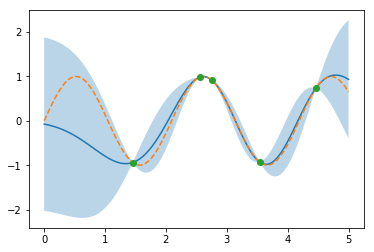

In [3]:
fig, ax = plt.subplots()

xx = np.linspace(0, 5, 100)

yy, ss = predictor(xx)

ax.plot(xx, yy)
ax.fill_between(xx, yy-1.96*np.sqrt(ss), yy+1.96*np.sqrt(ss), alpha=0.3)
ax.plot(xx, fun(xx), '--')
ax.plot(gp.X, gp.Y, 'o')

plt.show()